In [16]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [19]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
data_files = f'{hadoopUrl}/precipitation/data/agg/from/1955/*.parquet'

# Obtain dataset
df = spark.read.parquet(data_files).select("date","precipitation").toPandas()

In [20]:
# Set the date column as the index and ensure it's a DatetimeIndex
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,precipitation
date,
1956-01-01,3.596281
1956-01-02,8.505372
1956-01-03,0.068595
1956-01-04,0.023554
1956-01-05,0.042562


# Stationary Test

In [10]:
#%pip install arch

In [21]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)


In [22]:
#Montly
test_stationarity(df.precipitation)

ADF Test:
Test statistic: -42.28490083265054
null_hypothesis: the time series is non-stationary
P-value: 0.0
Critical values:
1%: -3.43061660080751
5%: -2.861657829385858
10%: -2.5668327171541385
STATIONARY

KPSS Test:
null_hypothesis: the time series is trend stationary
Test statistic: 0.058841542518399285
P-value: 0.1
Critical values:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216
STATIONARY


# SARIMA

In [40]:
def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    output = df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]
    print(f"Records removed: {df.shape[0] - output.shape[0]}")
    return output


In [41]:
# remove outliers
df_seasson = remove_outlier(df).resample('1M').mean()
df_seasson.shape

Records removed: 1856


(807, 1)

In [48]:
## Stationary test

In [49]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)

#Montly
test_stationarity(df_seasson.precipitation)

ADF Test:
Test statistic: -6.7975460478483924
null_hypothesis: the time series is non-stationary
P-value: 2.2805481460528986e-09
Critical values:
1%: -3.438602251755426
5%: -2.8651823762743245
10%: -2.5687095387840673
STATIONARY

KPSS Test:
null_hypothesis: the time series is trend stationary
Test statistic: 0.056258219673894494
P-value: 0.1
Critical values:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216
STATIONARY


## SARIMA

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

df_seasson = df.resample('1M').mean()
train_data = df_seasson.iloc[:-160]  # Adjust the number of months for testing as needed
test_data = df_seasson.iloc[-160:]


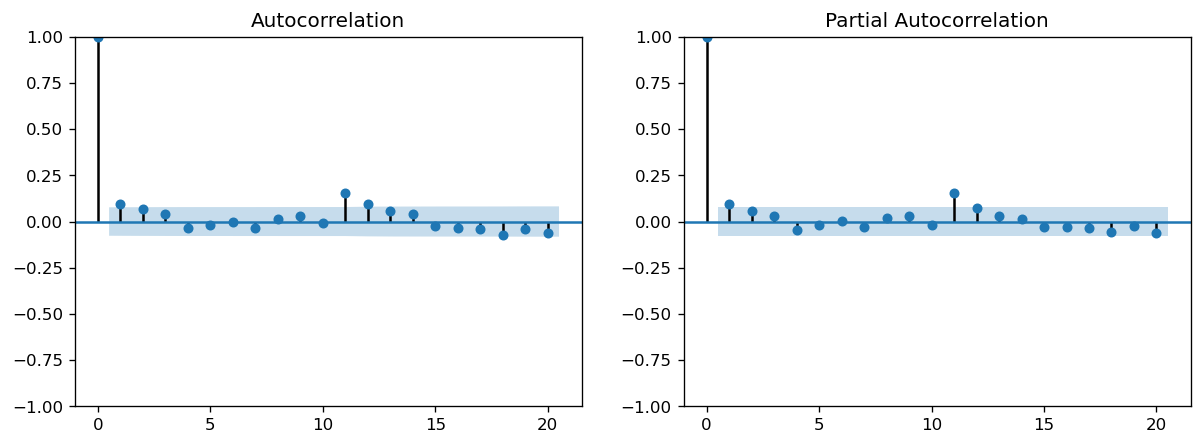

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_data, lags=20, ax=ax1)
plot_pacf(train_data, lags=20, ax=ax2)
plt.show()


In [44]:
p = 1
d = 0
q = 1
s = 12  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)
P = 1
D = 1
Q = 1

model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56504D+00    |proj g|=  2.80722D-01


 This problem is unconstrained.



At iterate    5    f=  1.47317D+00    |proj g|=  4.32300D-02

At iterate   10    f=  1.46526D+00    |proj g|=  6.97144D-03

At iterate   15    f=  1.46313D+00    |proj g|=  2.01944D-03

At iterate   20    f=  1.46310D+00    |proj g|=  3.27725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   1.148D-05   1.463D+00
  F =   1.4630972468064989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [46]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
print(f"RMSE: {rmse}")


RMSE: 1.0596176499672048


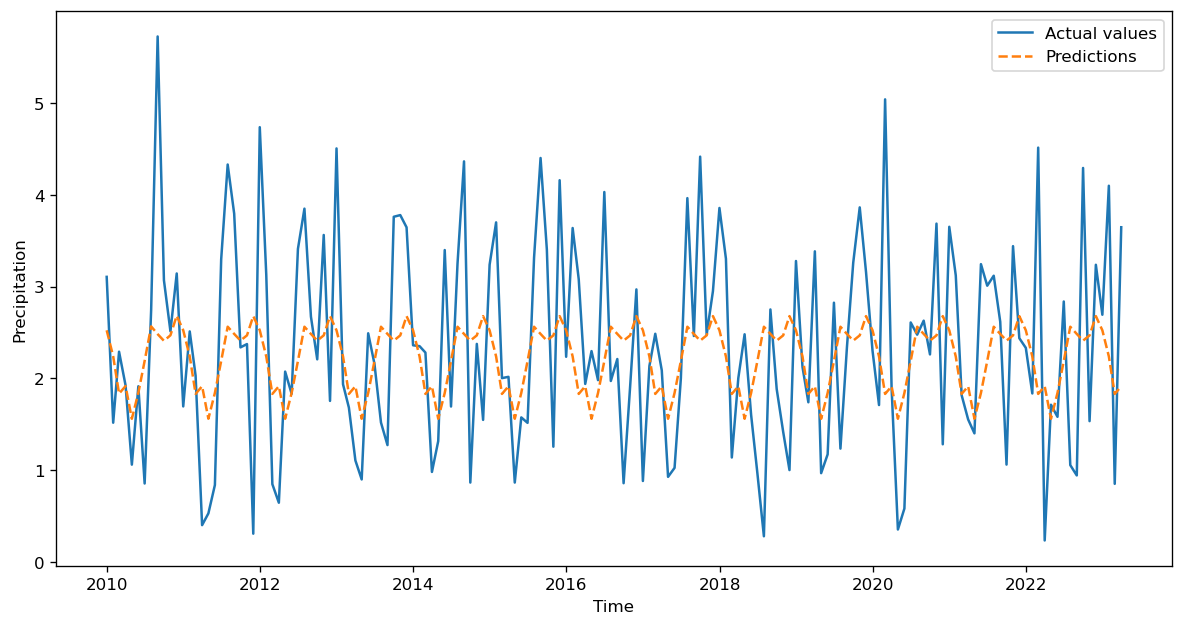

In [47]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()


## AUTO ARIMA

In [60]:
#%pip install pmdarima

In [73]:
import pmdarima as pm

df_seasson = df.resample('1M').mean()
train_data = df_seasson.iloc[:-160]  # Adjust the number of months for testing as needed
test_data = df_seasson.iloc[-160:]


auto_model = pm.auto_arima(train_data,
                      seasonal=True,
                      m=12,  # Seasonal frequency
                      start_p=0, start_q=0, max_p=3, max_q=3,  # Non-seasonal parameters
                      start_P=0, start_Q=0, max_P=3, max_Q=3,  # Seasonal parameters
                      d=None, D=None,  # Orders of differencing
                      trace=True,  # Print search information
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)  # Stepwise search for efficiency



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1946.486, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1940.619, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1941.296, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3010.460, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1942.693, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1941.986, Time=1.27 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1940.850, Time=0.31 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1942.447, Time=0.24 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1940.249, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1942.405, Time=0.11 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1941.663, Time=1.56 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept

In [74]:
print(f"Best SARIMA Model: {auto_model.order}, {auto_model.seasonal_order}")

Best SARIMA Model: (2, 0, 0), (1, 0, 0, 12)


In [79]:
model = SARIMAX(train_data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
results = model.fit(method='lbfgs')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92439D+00    |proj g|=  4.24668D-01

At iterate    5    f=  1.64510D+00    |proj g|=  3.41257D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     17      1     0     0   8.161D-06   1.645D+00
  F =   1.6449425592251379     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [77]:
predictions = results.get_forecast(steps=len(test_data))
mean_predictions = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test_data, mean_predictions))
print(f"RMSE: {rmse}")


RMSE: 1.818871121530407


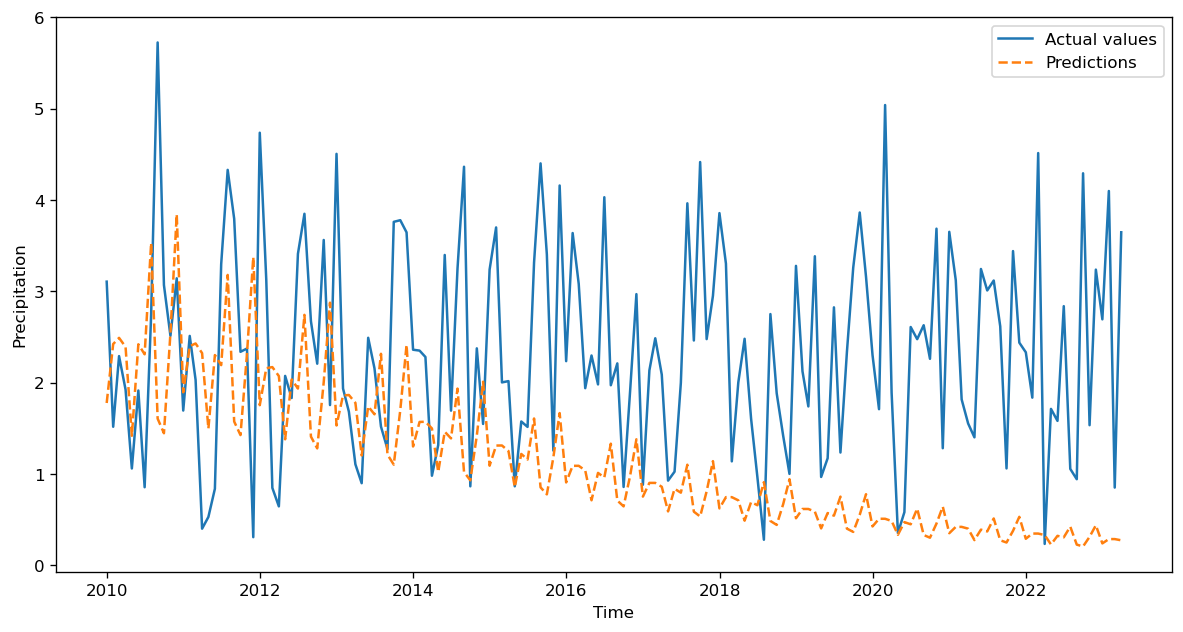

In [78]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual values')
plt.plot(mean_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()